In [1]:
from environments.e_greedy import DeepTradingEnvironment, LinearAgent
import datetime
import numpy as np
import pandas as pd
import os
from utils import train_val_test
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.plotting import plot_efficient_frontier
from pypfopt.cla import CLA
import matplotlib.pyplot as plt
import copy

# Utility Functions

In [2]:
def linear_agent_train(env, weights):
    x=np.array(list(weights.values())).reshape(-1,1)
    p_vol=np.sqrt(np.matmul(np.matmul(x.T,cov),x))
    p_sharpe=np.matmul(x.T,mus)/p_vol
    linear_agent=LinearAgent(environment=env,out_reward_window_td=out_reward_window,
                             reward_function="cum_return",sample_observations=4)
    linear_agent.set_plot_weights(weights=np.array(list(weights.values())),
                                  benchmark_G=-p_vol.ravel()[0])
    return linear_agent

In [3]:
root = os.getcwd()

def plot_backtest(linear_agent_train, env_test, model):
    ## Create Plot of Backtest
    if not "backtest" in locals():
        backtest=None
    backtest=linear_agent_train.backtest_policy(epoch=1,backtest=backtest, env_test=env_test)
    plt.figure(figsize=(12,6))
    plt.plot(backtest,color="blue")
    plt.gcf().autofmt_xdate()
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel("Date", fontsize = 14)
    plt.ylabel("Forward Returns", fontsize = 14)
    plt.title("Backtest on Test Data: "+ model,fontsize = 16)
    plt.savefig(root+'/temp_persisted_data/backtest_'+model+'.png')
    plt.show()
    return backtest

# Train-Test Split

#### List ETFs with data

In [4]:
data_env = root+"/data_env/"
os.listdir(data_env)

['EEMV.parquet',
 'HYG.parquet',
 'MTUM.parquet',
 'QUAL.parquet',
 'SIZE.parquet',
 'USMV.parquet',
 'VLUE.parquet']

#### Store ETFs in Pandas DataFrame

In [5]:
assets_dict = {file: pd.read_parquet(data_env + "/" + file) for file in os.listdir(data_env)}
counter=0
for key, value in assets_dict.items():
    if counter==0:
        main_index=value.index
    else:
        main_index=main_index.join(value.index,how="inner")

for key, value in assets_dict.items():
    tmp_df=value.reindex(main_index)
    tmp_df=tmp_df.fillna(method='ffill')
    assets_dict[key]=tmp_df['close']

In [6]:
portfolio_df = pd.DataFrame()

for key, value in assets_dict.items():
    key = key.split(".")[0]
    tmp_df = pd.DataFrame(data=value)
    tmp_df.columns=[key]
    portfolio_df = pd.concat([portfolio_df, tmp_df], axis=1)

portfolio_df.index = pd.to_datetime(portfolio_df.index, errors='coerce').tz_localize(None)

In [7]:
y = pd.Series(None)
forward_return_date = pd.Timedelta(days=1)
return_dates = pd.Series(portfolio_df.index) + forward_return_date

C:\Users\micha\anaconda3\envs\e599a_py37\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


#### Perform Train/Test Split

In [8]:
last_index, embargo_td = train_val_test(portfolio_df, y, return_dates)

#### Write Training and Test datasets to parquet files

In [9]:
assets_dict = {file: pd.read_parquet(data_env + "/" + file) for file in os.listdir(data_env)}
for file in os.listdir(data_env):
    tmp_df = pd.read_parquet(data_env + "/" + file)

    tmp_df_train = tmp_df.iloc[:last_index-embargo_td]
    tmp_df_train.to_parquet("data_env_train/" + file)
    tmp_df_test = tmp_df.iloc[last_index:] 
    tmp_df_test.to_parquet("data_env_test/" + file)

# Set Up Environment

#### Environment for Training Data

In [10]:
out_reward_window=datetime.timedelta(days=1)
# parameters related to the transformation of data, this parameters govern an step before the algorithm
meta_parameters = {"in_bars_count": 30,
                   "out_reward_window":out_reward_window ,
                   "state_type":"in_window_out_window",
                   "include_previous_weights":False}

# parameters that are related to the objective/reward function construction
objective_parameters = {"percent_commission": .001,
                        }
print("===Meta Parameters===")
print(meta_parameters)
print("===Objective Parameters===")
print(objective_parameters)


env = DeepTradingEnvironment.build_environment_from_dirs_and_transform(meta_parameters, objective_parameters,data_hash="real_data_train", data_dir="data_env_train")

number_of_assets = env.number_of_assets

sigma = np.zeros(number_of_assets)
mus = np.zeros(number_of_assets)
for i in range(0,number_of_assets):
    sigma[i] = np.std(env.features.iloc[:,i])**2
    mus[i] = np.mean(env.features.iloc[:,i])
    
cov = np.zeros((number_of_assets, number_of_assets))
np.fill_diagonal(cov, sigma)

ef = EfficientFrontier(mus, cov)
# weights = ef.max_sharpe(risk_free_rate=0)
weights = ef.min_volatility()
print("minimum volatility weights",weights)


===Meta Parameters===
{'in_bars_count': 30, 'out_reward_window': datetime.timedelta(days=1), 'state_type': 'in_window_out_window', 'include_previous_weights': False}
===Objective Parameters===
{'percent_commission': 0.001}
minimum volatility weights OrderedDict([(0, 0.0867482498843585), (1, 0.5149029197471017), (2, 0.0494995602862861), (3, 0.0633354683620407), (4, 0.0728418293690376), (5, 0.1588570816910145), (6, 0.0538148906601734)])


#### Environment for Test Data

In [11]:
env_test = DeepTradingEnvironment.build_environment_from_dirs_and_transform(meta_parameters, objective_parameters,data_hash="real_data_test", data_dir="data_env_test")

# Run Policy-Gradient Algorithms on Real-World Data

#### REINFORCE

In [12]:
max_iter = 1000

# create environment and run REINFORCE
env_reinforce = DeepTradingEnvironment.build_environment_from_dirs_and_transform(meta_parameters, objective_parameters,data_hash="real_data_train", data_dir="data_env_train")
linear_agent_reinforce = linear_agent_train(env_reinforce, weights)
linear_agent_reinforce.REINFORCE_fit(max_iterations=max_iter, add_baseline=False, verbose=False)

100%|██████████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:56<00:00, 10.76it/s]

[]

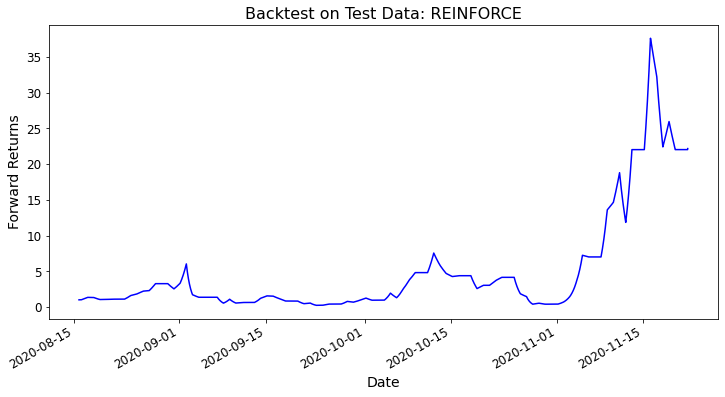

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:58<00:00, 17.22it/s]


In [13]:
# save weights from training model run
reinforce_train_weights = env_reinforce.state.weight_buffer.iloc[-1]
reinforce_train_weights.to_csv('temp_persisted_data/reinforce_train_weights.csv')

# perform backtest 
backtest_reinforce = plot_backtest(linear_agent_reinforce, env_test, model="REINFORCE")
backtest_reinforce.to_csv('temp_persisted_data/backtest_reinforce.csv')

#### REINFORCE with Baseline

In [14]:
# create environment and run REINFORCE with baseline
env_reinforce_baseline = DeepTradingEnvironment.build_environment_from_dirs_and_transform(meta_parameters, objective_parameters,data_hash="real_data_train", data_dir="data_env_train")
linear_agent_reinforce_baseline = linear_agent_train(env_reinforce_baseline, weights)
linear_agent_reinforce_baseline.REINFORCE_fit(max_iterations=max_iter, add_baseline=True, verbose=False)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:36<00:00, 12.81it/s]

[]

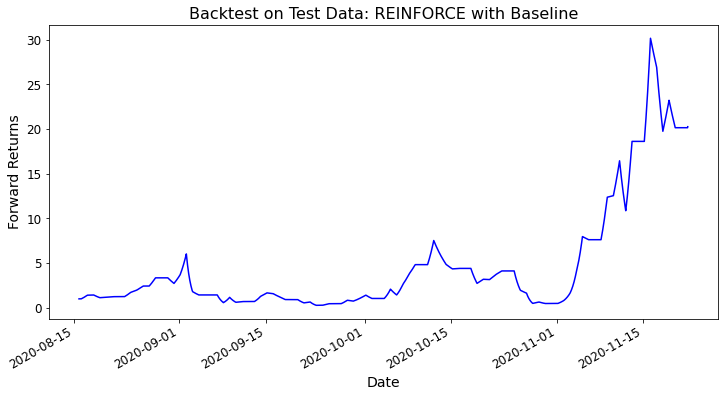

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:38<00:00, 10.18it/s]


In [15]:
# save weights from training model run
reinforce_baseline_train_weights = env_reinforce_baseline.state.weight_buffer.iloc[-1]
reinforce_baseline_train_weights.to_csv('temp_persisted_data/reinforce_baseline_train_weights.csv')

# perform backtest 
backtest_reinforce_baseline = plot_backtest(linear_agent_reinforce_baseline, env_test, model="REINFORCE with Baseline")
backtest_reinforce_baseline.to_csv('temp_persisted_data/backtest_reinforce_baseline.csv')

#### Actor-Critic with Eligibility Traces

In [16]:
# create environment and run Actor-Critic with Eligibility Traces 
env_actor_critic_trace = DeepTradingEnvironment.build_environment_from_dirs_and_transform(meta_parameters, objective_parameters,data_hash="real_data_train", data_dir="data_env_train")
linear_agent_actor_critic_trace = linear_agent_train(env_actor_critic_trace, weights)
linear_agent_actor_critic_trace.ACTOR_CRITIC_FIT(use_traces=True,max_iterations=max_iter, verbose=False)

100%|██████████████████████████████████████████████████████████████████████████████▉| 999/1000 [01:41<00:00,  9.99it/s]

[]

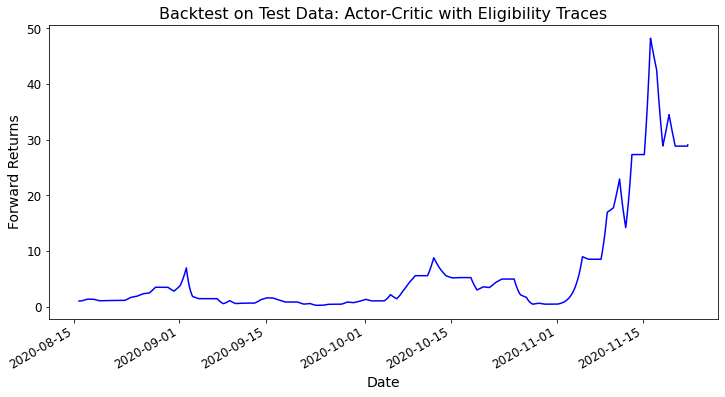

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:43<00:00,  9.68it/s]


In [17]:
# save weights from training model run
actor_critic_trace_train_weights = env_actor_critic_trace.state.weight_buffer.iloc[-1]
actor_critic_trace_train_weights.to_csv('temp_persisted_data/actor_critic_trace_train_weights.csv')

# perform backtest 
backtest_actor_critic_trace = plot_backtest(linear_agent_actor_critic_trace, env_test, model="Actor-Critic with Eligibility Traces")
backtest_actor_critic_trace.to_csv('temp_persisted_data/backtest_actor_critic_trace.csv')

#### Actor-Critic without Eligibility Traces

In [18]:
# create environment and run Actor-Critic with Eligibility Traces 
env_actor_critic_no_trace = DeepTradingEnvironment.build_environment_from_dirs_and_transform(meta_parameters, objective_parameters,data_hash="real_data_train", data_dir="data_env_train")

linear_agent_actor_critic_no_trace = linear_agent_train(env_actor_critic_no_trace, weights)
linear_agent_actor_critic_no_trace.ACTOR_CRITIC_FIT(use_traces=False,max_iterations=max_iter, verbose=False)

100%|██████████████████████████████████████████████████████████████████████████████▉| 999/1000 [01:43<00:00,  9.59it/s]

[]

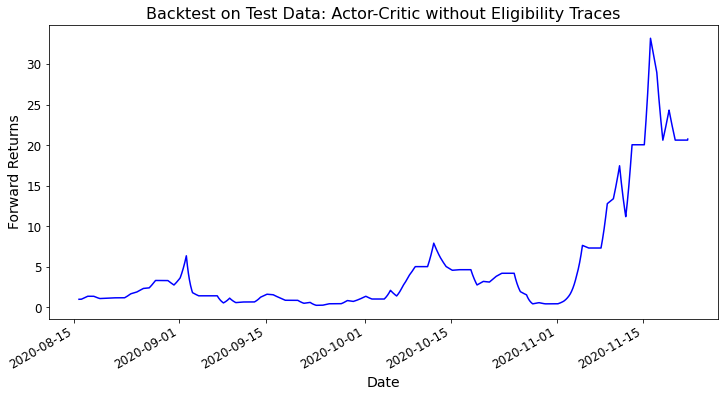

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:44<00:00,  9.52it/s]


In [19]:
# save weights from training model run
actor_critic_no_trace_train_weights = env_actor_critic_no_trace.state.weight_buffer.iloc[-1]
actor_critic_no_trace_train_weights.to_csv('temp_persisted_data/actor_critic_no_trace_train_weights.csv')

# perform backtest
backtest_actor_critic_no_trace = plot_backtest(linear_agent_actor_critic_no_trace, env_test, model="Actor-Critic without Eligibility Traces")
backtest_actor_critic_no_trace.to_csv('temp_persisted_data/backtest_actor_critic_no_trace.csv')